# EECS 545 (WN 2024) Homework 4: Convolutional Neural Networks

<span class="instruction">Before starting the assignment, please fill in the following cell.</span>

In [2]:
###################################################################
# Enter your first and last name, e.g. "John Doe"                 #
# for example                                                     #
# __NAME__ = "Anthony Liu"                                        #
# __UNIQID__ = "anthliu"                                          #
###################################################################
# raise NotImplementedError("TODO: Add your implementation here.")‘
__NAME__ = "Wensong Hu"
__UNIQID__ = "umhws" 
###################################################################
#                        END OF YOUR CODE                         #
###################################################################

print(f"Your name and email: {__NAME__} <{__UNIQID__}@umich.edu>")
assert __NAME__ and __UNIQID__

Your name and email: Wensong Hu <umhws@umich.edu>


# CNNs and MNIST
In this notebook, you will test your convolution layer implementation from `layers.py` and then test your CNN implementation from `cnn.py` on the MNIST dataset.

## Setup code
Before getting started, we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook. Let's start by checking whether we are using Python 3.11 or higher.

In [3]:
import sys
if sys.version_info[0] < 3:
    raise Exception("You must use Python 3")

if sys.version_info[1] < 11:
    print("Autograder will execute your code based on Python 3.11 environment. Please use Python 3.11 or higher to prevent any issues")
    print("You can create a conda environment with Python 3.11 like 'conda create --name eecs545 python=3.11'")
    raise Exception("Python 3 version is too low: {}".format(sys.version))
else:
    print("You are good to go")

You are good to go


First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [4]:
%load_ext autoreload
%autoreload 2

Then, we run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [5]:
# install required libraries
# !pip install numpy==1.24.1 matplotlib==3.6.2 scikit-learn==1.2.0 imageio==2.25.1

# import libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# set figure size
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

In [6]:
from IPython.display import display_html, HTML

display_html(HTML('''
<style type="text/css">
  .instruction { background-color: yellow; font-weight:bold; padding: 3px; }
</style>
'''));

Running the following cell allow us to import from `cnn_layers.py` and `cnn.py`. If it works correctly, it should print the message:
```Hello from cnn_layers.py``` and ```Hello from cnn.py```

In [7]:
from cnn_layers import hello
from cnn import hello as hello2
hello()
hello2()

Hello from cnn_layers.py!
Hello from cnn.py!


# Convolution Layer
Let's test your `conv_forward` and `conv_backward` implementations on some toy data!

In [8]:
# toy dataset
import matplotlib.pyplot as plt

def gen_toy_data(dim, fdim):
    # Generate data
    coords_x, coords_y = np.meshgrid(np.linspace(-1, 1, num=dim), np.linspace(-1, 1, num=dim))
    X = np.zeros((1, 3, dim, dim))# N, C, H, W
    X[:, 0] = np.sin(10 * (coords_x**2 + coords_y**2))**2
    X[:, 1] = np.clip(np.sin(5 * coords_x) * np.cos(5 * coords_y), 0, 1)
    X[:, 2] = np.clip(np.sin(2 * coords_x - 1) * np.cos(2 * coords_y - 1) * 2, 0, 1)

    # Create filter
    K = np.zeros((3, 3, fdim, fdim))
    K[0, 0] = np.eye(fdim) / fdim# diagonals on the red channel
    K[1, 1] = (1 / fdim)**2# blur on the green channel
    K[2, 2, 2, 2] = 0.5# dim on the blue channel
    
    return X, K

# visualize toy data:
def visualize(**kwargs):
    n_plots = len(kwargs)
    for i, (title, im_array) in enumerate(kwargs.items()):
        im = im_array[0].transpose(1, 2, 0)
        plt.subplot(1, n_plots, i+1)
        plt.axis('off')
        plt.imshow(im)
        plt.title(title)

### Forward pass with a toy dataset

<span class="instruction">Please complete the forward pass code in `conv_forward` of `layers.py`</span>.

First, we'll visualize some convolutions.

In [9]:
from cnn_layers import conv_forward

dim, filter_dim = 42, 7
X, K = gen_toy_data(dim, filter_dim)
# Convolute!
Y, _ = conv_forward(X, K)
assert Y.shape == (1, 3, dim - filter_dim + 1, dim - filter_dim + 1), 'conv_forward needs to output the right shape'

### Visualizing toy dataset filters

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


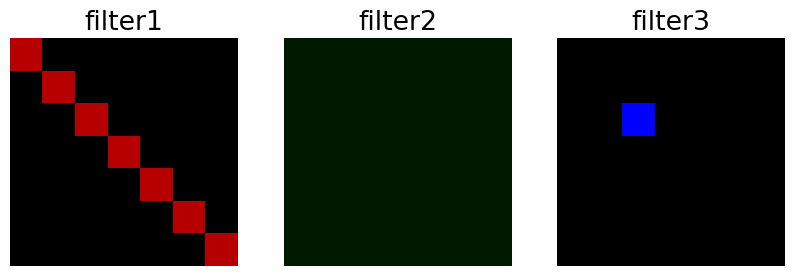

In [10]:
visualize(filter1=K[:1]*5, filter2=K[1:2]*5, filter3=K[2:3]*5)

### After applying filters

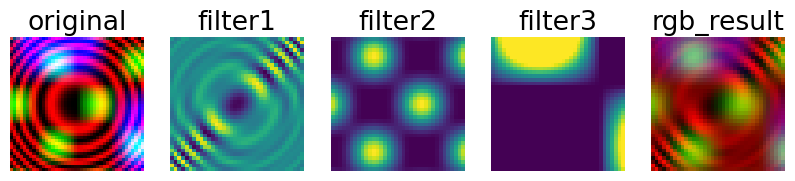

In [11]:
visualize(original=X, filter1=Y[:,:1], filter2=Y[:,1:2], filter3=Y[:,2:3], rgb_result=Y)

The visualization above should show an image of the data `X` and the resulting image after we applied `conv_forward` with filter `K`. If you've implemented it correctly, you should see the effects of a diagonal detector, a blur filter, and a dimming filter.

Next, let's check the correct output. The distance gap between your output and the answer should be smaller than 1e-7.

In [12]:
from gradient_check import rel_error
from cnn_layers import conv_forward

rng = np.random.default_rng(545)
X_small = rng.standard_normal((2, 5, 7, 7))
K_small = rng.standard_normal((3, 5, 5, 5))
out, _ = conv_forward(X_small, K_small)
correct_out = np.array([[[[ -3.34842932, -11.24497879, -17.38198515],
         [-16.15896725,   7.72160921,  -4.15308656],
         [-14.15831022,   4.10279395,  13.77403336]],

        [[ 16.62204065,  -7.75246004,  11.79562067],
         [ 14.743906  ,  19.39098536,   5.61990191],
         [  5.20928401,   6.58039498,  -0.83129394]],

        [[  5.33574113,  -4.44273441,  -7.39770074],
         [-29.1247239 , -16.20540086,   2.7399245 ],
         [  1.50572319, -11.91123209,  11.04276442]]],


       [[[ 15.33280328,   8.01117459,  -1.50598594],
         [ 11.75451706,  -2.36205181, -10.45831398],
         [ -0.59063047,  14.84211664, -13.20034552]],

        [[ -6.51979022,  16.46156252,   7.78735469],
         [  2.73587298, -13.21628187, -28.46179666],
         [ 18.35279877,  -6.91822886,  14.98855234]],

        [[  5.85132249, -10.14699364,  -8.81940002],
         [ -5.72420267, -10.56289559,  -8.27292934],
         [ 13.06061067,  -9.34632771,  24.01649138]]]])
# Compare your output with ours. The error might be less than 1e-7.
# As long as your error is small enough, your implementation should pass this test.
print('Testing conv_forward function:')
print('difference: ', rel_error(out, correct_out))
print()
np.testing.assert_allclose(out, correct_out, atol=1e-6)

Testing conv_forward function:
difference:  3.5844266915771246e-09



In [14]:
from gradient_check import rel_error, eval_numerical_gradient_array
from cnn_layers import conv_forward, conv_backward

rng = np.random.default_rng(545)
x = rng.standard_normal((2, 5, 7, 7))
k = rng.standard_normal((3, 5, 5, 5))
dout = rng.standard_normal((2, 3, 3, 3))

dx_num = eval_numerical_gradient_array(lambda x: conv_forward(x, k)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda k: conv_forward(x, k)[0], k, dout)

_, cache = conv_forward(x, k)
dx, dw = conv_backward(dout, cache)
# The error should be around 1e-7
print('\nTesting conv_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print()

np.testing.assert_allclose(dx, dx_num, atol=1e-7)
np.testing.assert_allclose(dw, dw_num, atol=1e-7)


Testing conv_backward function:
dx error:  3.405815354551183e-07
dw error:  2.629647828926602e-08



# Max Pooling Layer

The forward and backward passes of `max_pool_forward` and `max_pool_backward` implementations have been implemented for you.
Let's visualize and check the instructor solution!

In [15]:
from cnn_layers import max_pool_forward

dim, filter_dim = 42, 7
X, _ = gen_toy_data(dim, filter_dim)
# Max Pool!
Y, _ = max_pool_forward(X, {'pool_height': 3, 'pool_width': 3, 'stride': 2})
assert Y.shape == (1, 3, 20, 20), 'max_pool_forward needs to output the right shape'

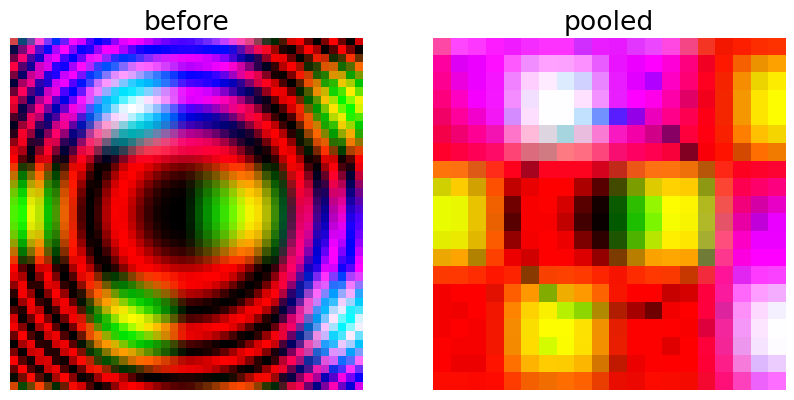

In [16]:
visualize(before=X, pooled=Y)

Lets check for the correct output.

In [17]:
from gradient_check import rel_error
from cnn_layers import max_pool_forward

X_small, _ = gen_toy_data(7, 3)
out, _ = max_pool_forward(X_small, {'pool_height': 3, 'pool_width': 3, 'stride': 2})
correct_out = np.array([[[[0.98671053, 0.98671053, 0.98671053],
         [0.98671053, 0.80316046, 0.98671053],
         [0.98671053, 0.98671053, 0.98671053]],

        [[0.97716612, 0.97716612, 0.94135103],
         [0.95892427, 0.99540796, 0.99540796],
         [0.97716612, 0.97716612, 0.94135103]],

        [[1.        , 1.        , 0.64784059],
         [0.19056796, 0.19056796, 1.        ],
         [0.        , 0.        , 1.        ]]]])
# Compare your output with ours. The error might be less than 1e-7.
# As long as your error is small enough, your implementation should pass this test.
print('Testing max_pool_forward function:')
print('difference: ', rel_error(out, correct_out))
print()
np.testing.assert_allclose(out, correct_out, atol=1e-6)

Testing max_pool_forward function:
difference:  7.544514187722353e-09



### Backward pass
Next we'll test the instructor implementation using numeric gradient checking

In [18]:
from gradient_check import rel_error, eval_numerical_gradient_array
from cnn_layers import max_pool_forward, max_pool_backward

rng = np.random.default_rng(545)
x = rng.standard_normal((3, 2, 7, 7))
pool_param = {
    'pool_height': 3,
    'pool_width': 3,
    'stride': 2
}
dout = rng.standard_normal((3, 2, 3, 3))

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward(x, pool_param)[0], x, dout)

_, cache = max_pool_forward(x, pool_param)
dx = max_pool_backward(dout, cache)
# The error should be around 1e-9
print('\nTesting conv_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print()

np.testing.assert_allclose(dx, dx_num, atol=1e-7)


Testing conv_backward function:
dx error:  3.2756953725548557e-12



# CNN
As we have all components, <span class="instruction">now we would like to implement the `ConvNet` class in `cnn.py'.</span> Read through it to make sure you understand the API. You can run the cell below to test your implementation.

### Initialization Test
Some checks to make sure `ConvNet` is initialized correctly. Hint: Make sure the shape for W3 layer is calculated correctly!

In [19]:
from gradient_check import rel_error, eval_numerical_gradient, eval_numerical_gradient_array
from cnn import ConvNet

rng = np.random.default_rng(545)
N, C, H, W, K = 3, 3, 23, 23, 7
num_filters_1, num_filters_2, filter_size, hidden_dim = 3, 4, 4, 17
X = rng.standard_normal((N, C, H, W))
y = rng.integers(K, size=N)

model = ConvNet(input_dim=(C, H, W), num_filters_1=num_filters_1, num_filters_2=num_filters_2, filter_size=filter_size, hidden_dim=hidden_dim, num_classes=K)

print('Testing initialization... ')
_W1 = model.params['W1']
_W2 = model.params['W2']
_W3 = model.params['W3']
_b3 = model.params['b3']
_W4 = model.params['W4']
_b4 = model.params['b4']
assert _W1.shape == (3, 3, 4, 4), 'W1 shape incorrect'
assert _W2.shape == (4, 3, 4, 4), 'W2 shape incorrect'
assert _W3.shape == (36, 17), 'W3 shape incorrect'
assert _b3.shape == (17,), 'b3 shape incorrect'

assert -0.145 < _W1.min() < _W1.max() < 0.145, 'W1 initialization range is incorrect'
assert -0.145 < _W2.min() < _W2.max() < 0.145, 'W2 initialization range is incorrect'
assert -0.167 < _W3.min() < _W3.max() < 0.167, 'W2 initialization range is incorrect'
print('Passed.')

Testing initialization... 
Passed.


### Forward and Backward correctness

We will test the `ConvNet.loss` function here.

In [21]:
from gradient_check import rel_error, eval_numerical_gradient, eval_numerical_gradient_array
from cnn import ConvNet

rng = np.random.default_rng(545)
N, C, H, W, K = 3, 3, 12, 12, 7
num_filters_1, num_filters_2, filter_size, hidden_dim = 3, 3, 3, 10
X = rng.standard_normal((N, C, H, W))
y = rng.integers(K, size=N)

model = ConvNet(input_dim=(C, H, W), num_filters_1=num_filters_1, num_filters_2=num_filters_2, filter_size=filter_size, hidden_dim=hidden_dim, num_classes=K)

reinit_like = lambda v, lb, ub: np.linspace(lb, ub, num=np.product(v.shape)).reshape(*v.shape)
model.params['W1'] = reinit_like(model.params['W1'], -0.7, 0.3)
model.params['W2'] = reinit_like(model.params['W2'], -0.3, 0.4)
model.params['W3'] = reinit_like(model.params['W3'], -0.3, 0.4)
model.params['b3'] = reinit_like(model.params['b3'], -0.9, 0.1)
model.params['W4'] = reinit_like(model.params['W4'], -0.3, 0.4)
model.params['b4'] = reinit_like(model.params['b4'], -0.9, 0.1)

scores = model.loss(X)
correct_scores = np.array([[1.6207142 , 2.01765557, 2.41459693, 2.81153829, 3.20847965,
        3.60542102, 4.00236238],
       [2.14212509, 2.61687778, 3.09163046, 3.56638314, 4.04113582,
        4.51588851, 4.99064119],
       [1.4395262 , 1.80835977, 2.17719335, 2.54602692, 2.91486049,
        3.28369406, 3.65252763]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

loss, grads = model.loss(X, y)

# relative error should be less than 1e-7
for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

/tmp/ipykernel_3500414/3664010476.py:13: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  model.params['W1'] = reinit_like(model.params['W1'], -0.7, 0.3)
/tmp/ipykernel_3500414/3664010476.py:14: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  model.params['W2'] = reinit_like(model.params['W2'], -0.3, 0.4)
/tmp/ipykernel_3500414/3664010476.py:15: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  model.params['W3'] = reinit_like(model.params['W3'], -0.3, 0.4)
/tmp/ipykernel_3500414/3664010476.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  model.params['b3'] = reinit_like(model.params['b3'], -0.9, 0.1)
/tmp/ipykernel_3500414/3664010476.py:17: DeprecationWarning: `product` i

W1 relative error: 4.53e-09
W2 relative error: 1.02e-08
W3 relative error: 1.49e-09
W4 relative error: 6.87e-10
b3 relative error: 1.08e-09
b4 relative error: 3.78e-10


## Let's test our model with a dataset: CIFAR-10
You tested a two-layer-net on the MNIST dataset in HW3. For HW4, we will test on a slightly more challenging dataset: CIFAR10. CIFAR10 (along with MNIST) is a commonly used dataset for image processing systems. Given its simplicity, it is often used for sanity tests and toy implementations.
CIFAR10 has 10 classes (hence the name CIFAR**10**): `('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')`.
CIFAR10 is more challenging than MNIST because it also includes color, and its classes are more difficult to distinguish than digits.

You will test your implementation on this dataset. Optionally, you can also test your implementation on MNIST (and see if your implementation beats the two-layer-net). However, please submit the results from the **cifar-10** dataset.

We will install PyTorch and PyTorchVision to use their CIFAR-10 dataset loader. (You will use PyTorch later in the transfer learning problem)

In [ ]:
# !pip install torch torchvision

In [22]:
# Set this to 'cifar' or 'mnist'
DATASET = 'cifar'

In [23]:
from image_utils import process_mnist, process_cifar
if DATASET == 'cifar':
    loader = process_cifar
elif DATASET == 'mnist':
    loader = process_mnist
else:
    raise ValueError
q2_data = loader('data', visualize=True)

ModuleNotFoundError: No module named 'imageio'

### Train the network
Let's train our CNN network! You may want to run this while doing something else. The instructor solution takes around an hour to complete 3 epochs.

In [ ]:
import solver
from cnn import ConvNet

C, H, W = q2_data['X_train'][0].shape
K = 10
num_filters_1, num_filters_2, filter_size, hidden_dim = 6, 16, 5, 100
num_epochs = 3# you may train for more epochs if you have time, but 3 is sufficient

model = ConvNet(input_dim=(C, H, W), num_filters_1=num_filters_1, num_filters_2=num_filters_2, filter_size=filter_size, hidden_dim=hidden_dim, num_classes=K)

# the update rule of 'adam' can be used to replace 'sgd' if it is helpful.
s = solver.Solver(model, q2_data,
                   update_rule='sgd',
                   optim_config={'learning_rate': 1e-3, 'momentum': 0.9},
                   lr_decay=0.95,
                   num_epochs=num_epochs, batch_size=25,
                   print_every=200)
s.train()

Let's plot the loss function and the accuracies on the training and validation sets during optimization. <span class="instruction">Please report 'cnn.png' file in your **writeup**.</span>

In [ ]:
plt.subplot(1, 2, 1)
plt.title('Training loss')
plt.plot(s.loss_history, '.')
plt.xlabel('Iteration')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(s.train_acc_history, '-o', label='train')
plt.plot(s.val_acc_history, '-x', label='val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(14, 6)

plt.savefig('cnn.png', dpi=256)

Lastly, we want to check the performance over the testset. (Our best model on CIFAR-10 and MNIST get around 43% and 98% test-set accuracy -- did you beat us?) <span class="instruction">Please report your test accuracy in your **writeup**</span>.

In [ ]:
test_acc = s.check_accuracy(X=np.array(q2_data['X_test'], np.float32), y=q2_data['y_test'])
print('Test accuracy: {:.2f}%'.format(test_acc * 100))

## (Extra) Visualizing the learned kernels

Now that we have a trained model, we can check what kernels the model has learned. If it follows what we've seen in lecture, we should see many edge detectors in the convolution layer.

In [ ]:
from image_utils import make_grid

In [ ]:
learned_filters = model.params['W1'].copy().transpose(0, 2, 3, 1)
ub, lb = learned_filters.max(), learned_filters.min()
learned_filters = (learned_filters - lb) / (ub - lb + 1e-4)

In [ ]:
plt.title('Learned filters in W1')
#make_grid(learned_filters.squeeze(1), 4, 8)
plt.imshow(make_grid(learned_filters, 3, padding=2))
plt.axis('off')
plt.show()

In [ ]:
learned_filters_2 = model.params['W2'].copy().transpose(0, 2, 3, 1)
# Filters in W2 have 6 channels, can't visualize, so we split the 16 filters into 32.
learned_filters_2 = learned_filters_2.reshape(2 * learned_filters_2.shape[0], learned_filters_2.shape[1], learned_filters_2.shape[2], -1)
ub, lb = learned_filters_2.max(), learned_filters_2.min()
learned_filters_2 = (learned_filters_2 - lb) / (ub - lb + 1e-4)

In [ ]:
plt.title('Learned filters in W2')
#make_grid(learned_filters.squeeze(1), 4, 8)
plt.imshow(make_grid(learned_filters_2, 8, padding=2))
plt.axis('off')
plt.show()

What do you see? When training with 6 and 16 filters in W1 and W2 the filters can be difficult to interpret in the instructor solution.